**"I / we certify that the code and data in this assignment were generated independently, using only the tools
and resources defined in the course and that I/we did not receive any external help, coaching, or contributions
during the production of this work."**

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import gym
from gym import spaces
from matplotlib.offsetbox import (AnnotationBbox, OffsetImage)
import cv2
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
class DQNmodel(nn.Module):
    
    def __init__(self, n_inputs, n_actions, lr,hiddennodes):
        super().__init__()
        self.hNodes = hiddennodes
        self.fc1 = nn.Linear(n_inputs, self.hNodes)
        self.fc2 = nn.Linear(self.hNodes,self.hNodes)
        self.fc3 = nn.Linear(self.hNodes,self.hNodes)
        self.fc4 = nn.Linear(self.hNodes, n_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        
    def forward(self, x):
        # x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [3]:
class experience:

    def __init__(self):
        self.exp_buffer = []


    def empty_buffer(self):

        self.exp_buffer = []

    def __len__(self):
        return len(self.exp_buffer)


    def log_exp(self, input_vector_s1, action_current, reward,input_vector_s2):
        input_vector_s1 = input_vector_s1.type(torch.float)
        input_vector_s2 = input_vector_s2.type(torch.float)
        action_current = torch.tensor(action_current).type(torch.float)
        reward = torch.tensor(reward).type(torch.float)

        exp_vector = [input_vector_s1, action_current,reward, input_vector_s2]

        self.exp_buffer.append(exp_vector)

    

    def get_exp(self):

        return self.exp_buffer

In [4]:
"""
  Most Probably the Q learning and sarsa function go over here.
"""

class RandomAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space # Observation Space
    self.action_space = env.action_space # Action space

  def epsilon_decay(self, current_eps, decay_factor, min_eps, current_episode, max_eps = 1):
    # Epsilon decay
    eps = max(current_eps*decay_factor, min_eps)
    # eps = min_eps + (max_eps - min_eps)* np.exp(-decay_factor*current_episode)
    return eps  
       
  def step(self, action, render_mode="Deterministic"):
    
    if render_mode == "Deterministic":
        action_step = action
    
    return action_step

In [5]:
import math
"""
This function is used for training the model

- Input Parameters 
    = Initial Epsilon 
    = Policy model object
    = Target model object
    = Experience object
    = Environment Object
    = Agent Object
    = Epochs
    = Batch size
    = Learning rate
    = Replay Size

DOUBLE DQN 
1 -> Double DQN
0 -> DQN

"""

def train_modelM(env, agent,model, exp, eps_init, epochs, replay_size, batch_size,hnodes, lr ,doubledqn):
  
    # Epsilon decay list for logging
    eps_decay_data = []

    # Score List for logging
    score_data = []

    # Setting the epsilon value to 1 at start
    eps= eps_init
    j = 1

    loss_list = []

    # Creating the policy model 
    policy = model(env.observation_space.shape[0],env.action_space.n,lr,hnodes)

    # Creating target model
    target = model(env.observation_space.shape[0],env.action_space.n,lr,hnodes)
    
   
    for x in range(epochs):
        
        # print(x)

        # Resetting the environment
        obs = env.reset()

        #print(obs)
        input_vector_s1_tensor = torch.from_numpy(obs)
        

        # Setting the inital paramters per episode
        done = False
        score = 0
        
        count = 0
        


        # While Loop
        while not done:
            
    
            count += 1
            
            
            # Selecting the greedy action or the random action depending the epsilon value
            if random.uniform(0,1) < eps:
                # Selecting some random number betwwen the action space 
                action_num = np.random.choice(env.action_space.n)
            else:
                # Selecting the greedy action
                input_vector_s1_tensor = input_vector_s1_tensor.type(torch.float)
                with torch.no_grad():
                    policy.eval()
                    action_num = torch.argmax(policy(input_vector_s1_tensor)).item()
                    #print(action_num)

            # First action that the agent is going to take before the while loop starts
            new_state, reward, done, _ = env.step(action_num)

            input_vector_s2_tensor = torch.from_numpy(new_state)
            reward=100*((math.sin(3*new_state[0]) * 0.0025 + 0.5 * new_state[1] * new_state[1]) - (math.sin(3*input_vector_s1_tensor.numpy()[0]) * 0.0025 + 0.5 * input_vector_s1_tensor.numpy()[1] * input_vector_s1_tensor.numpy()[1]))
            #print("after",reward)
            score +=reward
            # Appending the experience to the list
            exp.log_exp(input_vector_s1_tensor, action_num, reward, input_vector_s2_tensor)
            input_vector_s1_tensor =input_vector_s2_tensor

            #score += reward
            

            if exp.__len__() >= replay_size:
                j += 1
                #print("Training the model, length of batch size is ", len(exp_replay))
                batch = random.sample(exp.exp_buffer, batch_size)


                s1_batch = torch.stack([st1 for (st1, a1, r , st2) in batch])
                s2_batch = torch.stack([st2 for (st1, a1, r , st2) in batch])
                a_batch = torch.stack([a1 for (st1, a1, r , st2) in batch])
                r_batch = torch.stack([r for (st1, a1, r , st2) in batch])



                s1_batch = s1_batch.type(torch.float)
                s2_batch = s2_batch.type(torch.float)
                a_batch = a_batch.type(torch.float)
                policy_q = policy(s1_batch)
                policy_q1=policy(s2_batch)
                target_q = target(s2_batch)
                X = policy_q.gather(dim=1, index=a_batch.long().unsqueeze(dim=1)).squeeze()
                if(doubledqn==0):
                    Y = r_batch + disc_factor*(torch.max(target_q, dim=1)[0])
                else:
                    Y = r_batch + disc_factor*(torch.max(policy_q1, dim=1)[0])

                #print(r_batch)  
                #print(Y)
                loss  = policy.criterion(X,Y.detach())
                #print(loss)
                policy.optimizer.zero_grad()
                loss.backward()

                loss_list.append(loss.item())
                policy.optimizer.step()
                
                if j % 100 == 0:
                    target.load_state_dict(policy.state_dict())

                # Experience Replay
                exp.empty_buffer()

        #print(count)
        score_data.append(score)
        eps_decay_data.append(eps)
        # Epsilon Decay
        #if eps > min_eps:
            #eps *= decay_factor
        eps = agent.epsilon_decay(eps,decay_factor, min_eps,x)

    return eps_decay_data, score_data, policy


In [6]:

def evaluate_modelM(env, agent, trained_model, eval_epochs):
    # Score List for logging
    score_data1 = []

    # Episodes iteration
    for x in range(eval_epochs):

        # Resetting the environment
        obs = env.reset()

    
        input_vector_s1_tensor = torch.from_numpy(obs)
        

        # Setting the inital paramters per episode
        done = False
        score = 0
        
        env.reset()

        # While loop for the iterations
        while not done:

            with torch.no_grad():
                trained_model.eval()
                action_num = torch.argmax(trained_model(input_vector_s1_tensor.float())).item()
                # print(action_num)

            # Selection the action
            #action_current = agent.step(action_num)
            new_state, reward, done, _ = env.step(action_num)

            input_vector_s1_tensor = torch.from_numpy(new_state)
            
            # Adding the reward to the score
            score += reward
            env.render()
            # time.sleep(0.1)
            
        score_data1.append(score)
    env.close()
    return score_data1

**DQN**

In [7]:
m = gym.make("MountainCar-v0")
m.reset()
agent = RandomAgent(m)
exp = experience()
min_eps = 0.01
epochs  = 10000
decay_factor = float((min_eps)**(1/epochs))
eps_thres = 0.6
disc_factor = 0.99
replay_size = 500
batch_size = 256
#print(m.action_space.n)
x5, y5, model5 = train_modelM(m, agent, DQNmodel,exp, 1, epochs, replay_size, batch_size,256, 0.001,0)

**Rewards per episode and Epsilon Decay**

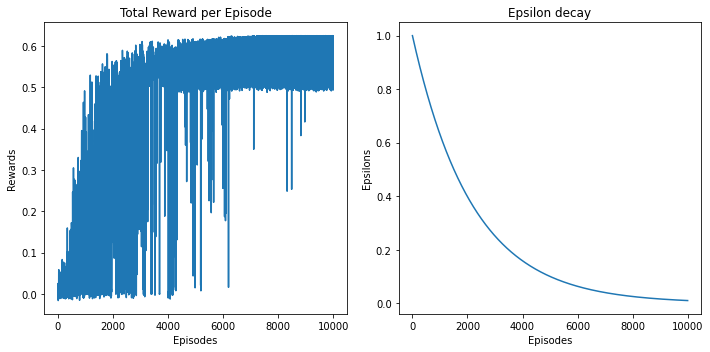

In [8]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
xn = range(len(y5))
plt.plot(xn,y5)
plt.title('Total Reward per Episode')
plt.ylabel('Rewards')
plt.xlabel('Episodes')


plt.subplot(1,2,2)
x1= range(len(x5))
plt.plot(x1,x5)
plt.title('Epsilon decay')
plt.ylabel('Epsilons')
plt.xlabel('Episodes')

fig.tight_layout()
plt.show()

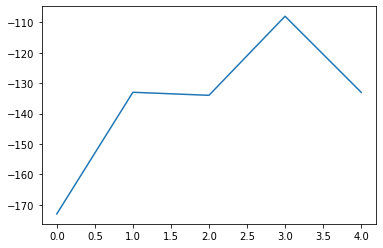

In [9]:
sd1 = evaluate_modelM(m, agent, model5, 5)
plt.plot(sd1)
# print(sd1)

**Double DQN**

In [10]:
m = gym.make("MountainCar-v0")
m.reset()
agent = RandomAgent(m)
exp = experience()
min_eps = 0.1
epochs  = 12000
decay_factor = float((min_eps)**(1/epochs))
eps_thres = 0.6
disc_factor = 0.8
replay_size = 1000
batch_size = 850
#print(m.action_space.n)
x6, y6, model6 = train_modelM(m, agent, DQNmodel,exp, 1, epochs, replay_size, batch_size,256, 0.001,1)

**Rewards per episode and Epsilon Decay**

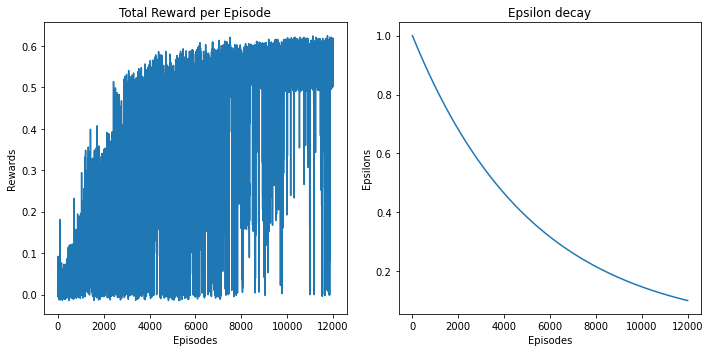

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
xn = range(len(y6))
plt.plot(xn,y6)
plt.title('Total Reward per Episode')
plt.ylabel('Rewards')
plt.xlabel('Episodes')


plt.subplot(1,2,2)
x1= range(len(x6))
plt.plot(x1,x6)
plt.title('Epsilon decay')
plt.ylabel('Epsilons')
plt.xlabel('Episodes')

fig.tight_layout()
plt.show()

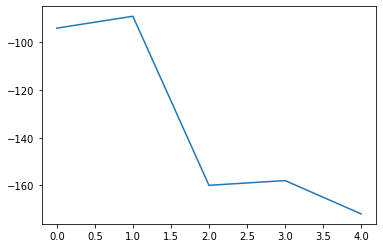

In [ ]:
sd1 = evaluate_modelM(m, agent, model6, 5)
plt.plot(sd1)